In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Tesla.csv to Tesla (1).csv


In [ ]:
!pip install hmmlearn

     |████████████████████████████████| 378kB 3.5MB/s 


In [ ]:
import warnings
import time
import sys
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
PLOT_SHOW=True
PLOT_TYPE = False

#Prediction Size
NUM_TEST = 100
#Window Size
K = 50
#Number of Iterations for Baum-Welch Algo to converge
NUM_ITERS=500

STOCKS=['Tesla.csv']

In [ ]:
#Observation Space
labels = ['Close','Open','High','Low']
# Possible number of states in Markov Model
STATE_SPACE = range(2,15)

In [ ]:
#Iterating over Stock in Stocks
#for stock in STOCKS:
stock='Tesla.csv'
dataset = np.genfromtxt(stock, delimiter=',')
predicted_stock_data = np.empty([0,dataset.shape[1]])
likelihood_vect = np.empty([0,1])
aic_vect = np.empty([0,1])
#bic_vect = np.empty([0,1])
#Finding Optimal Number of Hidden States Using BIC Score
for states in STATE_SPACE:
    num_params = states**2 + states
    #Fitting Model Using Baum-Welch Algorithm
    model = hmm.GaussianHMM(n_components=states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS)
    model.fit(dataset[NUM_TEST:,:])
    if model.monitor_.iter == NUM_ITERS:
        print('Increase number of iterations')
        sys.exit(1)
    #Finding Likelihood Using Forward Algorithm
    likelihood_vect = np.vstack((likelihood_vect, model.score(dataset)))
    #Calculating AIC Score
    aic_vect = np.vstack((aic_vect, -2 * model.score(dataset) + 2 * num_params))
    #Calculating BIC Score
    #bic_vect = np.vstack((bic_vect, -2 * model.score(dataset) +  num_params * np.log(dataset.shape[0])))
#Choosing the Optimal number of Hidden States corresponding to Least BIC Score
opt_states = np.argmin(aic_vect) + 2
print('Optimum number of states are {}'.format(opt_states))

Optimum number of states are 13


In [ ]:
aic_vect

array([[66765.31795727],
       [56101.67316559],
       [54158.70631283],
       [52953.77466629],
       [52402.86736538],
       [51694.15047913],
       [51185.98433239],
       [50930.64659836],
       [50748.34463179],
       [50470.67112459],
       [49976.4136035 ],
       [49786.54228625],
       [49967.40774198]])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


Text(0, 0.5, 'AIC Score')

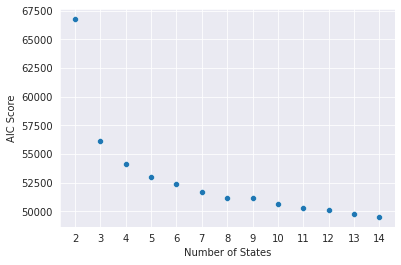

In [ ]:
sns.set_style('darkgrid')
sns.scatterplot(x=[2,3,4,5,6,7,8,9,10,11,12,13,14], y=aic_vect.flatten())
plt.xticks(range(2,15))
plt.xlabel('Number of States')
plt.ylabel('AIC Score')

In [ ]:
def calc_mape(predicted_data, true_data):
    return np.divide(np.sum(np.divide(np.absolute(predicted_data - true_data), true_data), 0), true_data.shape[0])

MAPE for the stock Tesla.csv is  [0.0539318  0.04530345 0.0511227  0.04038445]


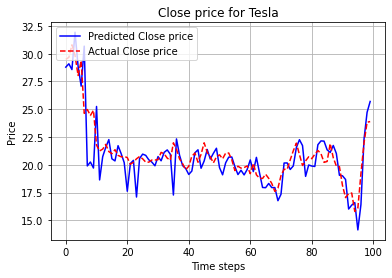

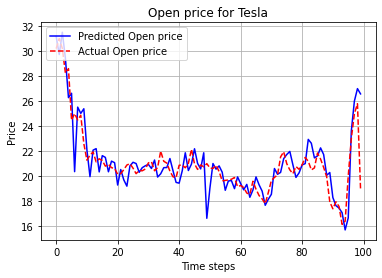

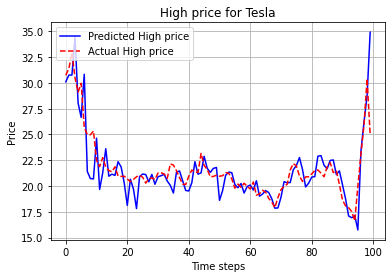

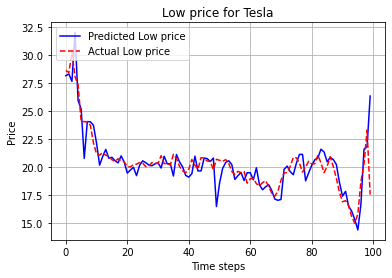

In [ ]:
 #Predicting Stock Prices Using HMM model with optimal number of Hidden States
for idx in reversed(range(NUM_TEST)):
    train_dataset = dataset[idx + 1:,:]
    test_data = dataset[idx,:]; 
    num_examples = train_dataset.shape[0]
    if idx == NUM_TEST - 1:
        model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS, init_params='stmc')
    else:
        # Return the model by using the HMM paramters from the previous iterations as the prior
        model = hmm.GaussianHMM(n_components=opt_states, covariance_type='full', tol=0.0001, n_iter=NUM_ITERS, init_params='')
        model.transmat_ = transmat_retune_prior 
        model.startprob_ = startprob_retune_prior
        model.means_ = means_retune_prior
        model.covars_ = covars_retune_prior
    
    #Fitting Model Using Baum-Welch Algorithm
    model.fit(np.flipud(train_dataset))

    transmat_retune_prior = model.transmat_
    startprob_retune_prior = model.startprob_
    means_retune_prior = model.means_
    covars_retune_prior = model.covars_

    if model.monitor_.iter == NUM_ITERS:
        print('Increase number of iterations')
        sys.exit(1)
    iters = 1;
    past_likelihood = []
    #Finding Previous Likelihood Similar to Current Likelihood using window of size K
    curr_likelihood = model.score(np.flipud(train_dataset[0:K - 1, :]))
    while iters < num_examples / K - 1:
        past_likelihood = np.append(past_likelihood, model.score(np.flipud(train_dataset[iters:iters + K - 1, :])))
        iters = iters + 1
    likelihood_diff_idx = np.argmin(np.absolute(past_likelihood - curr_likelihood))
    #Predicting Price usinh likelihood_difference
    predicted_change = train_dataset[likelihood_diff_idx,:] - train_dataset[likelihood_diff_idx + 1,:]
    predicted_stock_data = np.vstack((predicted_stock_data, dataset[idx + 1,:] + predicted_change))
np.savetxt('{}_forecast.csv'.format(stock),predicted_stock_data,delimiter=',',fmt='%.2f')

mape = calc_mape(predicted_stock_data, np.flipud(dataset[range(100),:]))
print('MAPE for the stock {} is '.format(stock),mape)

#Plotting
if PLOT_TYPE:
    hdl_p = plt.plot(range(100), predicted_stock_data);
    plt.title('Predicted stock prices')
    plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
    plt.xlabel('Time steps')
    plt.ylabel('Price')
    plt.figure()
    hdl_a = plt.plot(range(100),np.flipud(dataset[range(100),:]))
    plt.title('Actual stock prices')
    plt.legend(iter(hdl_p), ('Close','Open','High','Low'))
    plt.xlabel('Time steps')
    plt.ylabel('Price')
else:
    for i in range(4):
        plt.figure()
        plt.plot(range(100), predicted_stock_data[:,i],'-b', label = 'Predicted '+labels[i]+' price');
        plt.plot(range(100),np.flipud(dataset[range(100),i]),'--r', label = 'Actual '+labels[i]+' price')
        plt.xlabel('Time steps')
        plt.ylabel('Price')
        plt.title(labels[i]+' price'+ ' for '+ stock[:-4])
        plt.grid(True)
        plt.legend(loc = 'upper left')
    

if PLOT_SHOW:
    plt.show(block=False)